<a href="https://colab.research.google.com/github/dfangnon/RL_Final_Projects_AMMI2023/blob/main/RL_trading_system_good3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
from IPython.display import clear_output
clear_output()

In [ ]:
# let us set the device
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [ ]:
#In this notebook, we are going to train a reinforcement learning system
#!pip install yfinance
import yfinance as yf
from collections import namedtuple,deque
from torch import nn
import torch
from torch import optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import random

In [ ]:
#STATE_SPACE = 28
STATE_SPACE = 34
ACTION_SPACE = 3

ACTION_LOW = -1
ACTION_HIGH = 1

GAMMA = 0.9995
TAU = 1e-3
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 0.9

MEMORY_LEN = 10000
MEMORY_THRESH = 500
BATCH_SIZE = 200

LR_DQN = 5e-4

LEARN_AFTER = MEMORY_THRESH
LEARN_EVERY = 3
UPDATE_EVERY = 9

COST = 3e-4
CAPITAL = 100000
NEG_MUL = 2

### Now we need to generate the observation space. The following code snippet does the same. First, it downloads the required time series data for the given ticker, date and frequency from the Yahoo Finance website using yfinance python module. Later, it engineers the required features for the observation space.

In [ ]:
class DataGetter:
  """
  The class for getting data for assets.
  """

  def __init__(self, asset="BTC-USD", start_date=None, end_date=None, freq="1d",
               timeframes=[1,2,5, 10, 20, 40]):
    self.asset = asset
    self.sd = start_date
    self.ed = end_date
    self.freq = freq

    self.timeframes = timeframes
    self.getData()

    self.scaler = StandardScaler()
    self.scaler.fit(self.data[:, 1:])


  def getData(self):

    asset = self.asset
    if self.sd is not None and self.ed is not None:
      df =  yf.download([asset], start=self.sd, end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, end=self.ed, interval=self.freq)
    elif self.sd is None and self.ed is not None:
      df =  yf.download([asset], end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], end=self.ed, interval=self.freq)
    elif self.sd is not None and self.ed is None:
      df =  yf.download([asset], start=self.sd, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, interval=self.freq)
    else:
      df = yf.download([asset], period="max", interval=self.freq)
      df_spy = yf.download(["BTC-USD"], interval=self.freq)

    # Reward - Not included in Observation Space.
    #print(df_spy.head())
    df["rf"] = df["Adj Close"].pct_change().shift(-1)

    # Returns and Trading Volume Changes
    for i in self.timeframes:
      df_spy[f"spy_ret-{i}"] = df_spy["Adj Close"].pct_change(i)
      df_spy[f"spy_v-{i}"] = df_spy["Volume"].pct_change(i)

      df[f"r-{i}"] = df["Adj Close"].pct_change(i)
      df[f"v-{i}"] = df["Volume"].pct_change(i)

    # Volatility
    for i in [5, 10, 20, 40]:
      df[f'sig-{i}'] = np.log(1 + df["r-1"]).rolling(i).std()

    # Moving Average Convergence Divergence (MACD)
    df["macd_lmw"] = df["r-1"].ewm(span=26, adjust=False).mean()
    df["macd_smw"] = df["r-1"].ewm(span=12, adjust=False).mean()
    df["macd_bl"] = df["r-1"].ewm(span=9, adjust=False).mean()
    df["macd"] = df["macd_smw"] - df["macd_lmw"]

    # Relative Strength Indicator (RSI)
    rsi_lb = 5
    pos_gain = df["r-1"].where(df["r-1"] > 0, 0).ewm(rsi_lb).mean()
    neg_gain = df["r-1"].where(df["r-1"] < 0, 0).ewm(rsi_lb).mean()
    rs = np.abs(pos_gain/neg_gain)
    df["rsi"] = 100 * rs/(1 + rs)

    # Bollinger Bands
    bollinger_lback = 10
    df["bollinger"] = df["r-1"].ewm(bollinger_lback).mean()
    df["low_bollinger"] = df["bollinger"] - 2 * df["r-1"].rolling(bollinger_lback).std()
    df["high_bollinger"] = df["bollinger"] + 2 * df["r-1"].rolling(bollinger_lback).std()

    # SP500
    #print(self.timeframes)
    #df = df.merge(df_spy[[f"spy_ret-{i}" for i in self.timeframes] + [f"spy_sig-{i}" for i in [5, 10, 20, 40]]],
    df = df.merge(df_spy[[f"spy_ret-{i}" for i in self.timeframes]],
                  how="left", right_index=True, left_index=True)

    # Filtering
    for c in df.columns:
      df[c].interpolate('linear', limit_direction='both', inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    self.frame = df
    self.data = np.array(df.iloc[:, 6:])
    return


  def scaleData(self):
    self.scaled_data = self.scaler.fit_transform(self.data[:, 1:])
    return


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx, col_idx=None):
    if col_idx is None:
      return self.data[idx]
    elif col_idx < len(list(self.data.columns)):
      return self.data[idx][col_idx]
    else:
      raise IndexError


### The following snippet is the custom trading environment implementation for trading a single asset. It takes as input the DataGetter class for an asset. While there are a lot of functions in the environment class, the two main functions are step() and reset().

In [ ]:
class SingleAssetTradingEnvironment:
  """
  Trading Environment for trading a single asset.
  The Agent interacts with the environment class through the step() function.
  Action Space: {-1: Sell, 0: Do Nothing, 1: Buy}
  """

  def __init__(self, asset_data,
               initial_money=CAPITAL, trans_cost=COST, store_flag=1, asset_ph=0,
               capital_frac=0.2, running_thresh=0.1, cap_thresh=0.3):

    self.past_holding = asset_ph
    self.capital_frac = capital_frac # Fraction of capital to invest each time.
    self.cap_thresh = cap_thresh
    self.running_thresh = running_thresh
    self.trans_cost = trans_cost

    self.asset_data = asset_data
    self.terminal_idx = len(self.asset_data) - 1
    self.scaler = self.asset_data.scaler

    self.initial_cap = initial_money

    self.capital = self.initial_cap
    self.running_capital = self.capital
    self.asset_inv = self.past_holding

    self.pointer = 0
    self.next_return, self.current_state = 0, None
    self.prev_act = 0
    self.current_act = 0
    self.current_reward = 0
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.done = False

    self.store_flag = store_flag
    if self.store_flag == 1:
      self.store = {"action_store": [],
                    "reward_store": [],
                    "running_capital": [],
                    "port_ret": []}


  def reset(self):
    self.capital = self.initial_cap
    self.running_capital = self.capital
    self.asset_inv = self.past_holding

    self.pointer = 0
    self.next_return, self.current_state = self.get_state(self.pointer)
    self.prev_act = 0
    self.current_act = 0
    self.current_reward = 0
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.done = False

    if self.store_flag == 1:
      self.store = {"action_store": [],
                    "reward_store": [],
                    "running_capital": [],
                    "port_ret": []}

    return self.current_state


  def step(self, action):
    self.current_act = action
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.current_reward = self.calculate_reward()
    self.prev_act = self.current_act
    self.pointer += 1
    self.next_return, self.current_state = self.get_state(self.pointer)
    self.done = self.check_terminal()

    if self.done:
      reward_offset = 0
      ret = (self.store['running_capital'][-1]/self.store['running_capital'][-0]) - 1
      if self.pointer < self.terminal_idx:
        reward_offset += -1 * max(0.5, 1 - self.pointer/self.terminal_idx)
      if self.store_flag:
        reward_offset += 10 * ret
      self.current_reward += reward_offset

    if self.store_flag:
      self.store["action_store"].append(self.current_act)
      self.store["reward_store"].append(self.current_reward)
      self.store["running_capital"].append(self.capital)
      info = self.store
    else:
      info = None

    return self.current_state, self.current_reward, self.done, info


  def calculate_reward(self):
    investment = self.running_capital * self.capital_frac
    reward_offset = 0

    # Buy Action
    if self.current_act == 1:
      if self.running_capital > self.initial_cap * self.running_thresh:
        self.running_capital -= investment
        asset_units = investment/self.current_price
        self.asset_inv += asset_units
        self.current_price *= (1 - self.trans_cost)

    # Sell Action
    elif self.current_act == -1:
      if self.asset_inv > 0:
        self.running_capital += self.asset_inv * self.current_price * (1 - self.trans_cost)
        self.asset_inv = 0

    # Do Nothing
    elif self.current_act == 0:
      if self.prev_act == 0:
        reward_offset += -0.1
      pass

    # Reward to give
    prev_cap = self.capital
    self.capital = self.running_capital + (self.asset_inv) * self.current_price
    reward = 100*(self.next_return) * self.current_act - np.abs(self.current_act - self.prev_act) * self.trans_cost
    if self.store_flag==1:
      self.store['port_ret'].append((self.capital - prev_cap)/prev_cap)

    if reward < 0:
      reward *= NEG_MUL  # To make the Agent more risk averse towards negative returns.
    reward += reward_offset

    return reward


  def check_terminal(self):
    if self.pointer == self.terminal_idx:
      return True
    elif self.capital <= self.initial_cap * self.cap_thresh:
      return True
    else:
      return False


  def get_state(self, idx):
    state = self.asset_data[idx][1:]
    state = self.scaler.transform(state.reshape(1, -1))

    state = np.concatenate([state, [[self.capital/self.initial_cap,
                                     self.running_capital/self.capital,
                                     self.asset_inv * self.current_price/self.initial_cap,
                                     self.prev_act]]], axis=-1)

    next_ret = self.asset_data[idx][0]
    return next_ret, state

##Architecture (Online & Target Networks)

Architecture (Online & Target Networks)
The Agent contains two identical artificial neural networks known as online and target networks with the same architecture. The shape of input is the same as the shape of the state representation vector and the shape of output is the number of actions available. In our case, it is 3 (Buy, Sell & Do Nothing)

The online network is the one which learns from experiences and performs the optimisation step. Once every few timesteps, the weights of the online network are copied to the target network. Both the networks are used in the objective function. The online network is represented by Q(s, a; θ) and the target network is given by Q(s’, a; θ’) in the Bellman Equation given above. The learning step involves minimising the difference between LHS and RHS in the Bellman Equation.

The frequency of learning from experiences and updating the target network weights can be controlled by the parameters LEARN_AFTER, LEARN_EVERY and UPDATE_EVERY variables in the parameters code block.

Experience Replay
Every time the agent receives a state from the environment, it stores the experience tuple (current state, action taken, reward received, next state, indicator variable for terminal state) in a limited capacity memory, generally a Deque data structure. If the memory gets full, then new experiences will simply overwrite the old ones. Once enough experiences are collected, then the Agent randomly samples from these experiences and begins to learn every few timesteps.

This is required to prevent updating the weights of the neural network too soon with too few data points and also to eliminate the temporal correlation among the consecutive states given to the agent by the environment.

In [ ]:
Transition = namedtuple("Transition", ["States", "Actions", "Rewards", "NextStates", "Dones"])


class ReplayMemory:
  """
  Implementation of Agent memory
  """
  def __init__(self, capacity=MEMORY_LEN):
    self.memory = deque(maxlen=capacity)

  def store(self, t):
    self.memory.append(t)

  def sample(self, n):
    a = random.sample(self.memory, n)
    return a

  def __len__(self):
    return len(self.memory)

## Exploration vs Exploitation dilemma

The exploration vs. exploitation dilemma is a fundamental challenge in reinforcement learning. It involves allowing an agent to sometimes take random actions (exploration) rather than always following a fixed policy (exploitation). This randomness helps the agent learn how different actions affect rewards. During early training, more exploration is needed, while as training progresses, more exploitation is favored to maximize rewards. Parameters like EPS_START, EPS_END, and EPS_DECAY control this transition.

In [ ]:
class DuellingDQN(nn.Module):
  """
  Acrchitecture for Duelling Deep Q Network Agent
  """

  def __init__(self, input_dim=STATE_SPACE, output_dim=ACTION_SPACE):
    super(DuellingDQN, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.fc1 = nn.Linear(self.input_dim, 500)
    self.fc2 = nn.Linear(500, 500)
    self.fc3 = nn.Linear(500, 300)
    self.fc4 = nn.Linear(300, 200)
    self.fc5 = nn.Linear(200, 10)

    self.fcs = nn.Linear(10, 1)
    self.fcp = nn.Linear(10, self.output_dim)
    self.fco = nn.Linear(self.output_dim + 1, self.output_dim)

    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.sig = nn.Sigmoid()
    self.sm = nn.Softmax(dim=1)

  def forward(self, state):
    x = self.relu(self.fc1(state))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = self.relu(self.fc5(x))
    xs = self.relu(self.fcs(x))
    xp = self.relu(self.fcp(x))

    x = xs + xp - xp.mean()
    return x



In [ ]:
class SimpleDQN(nn.Module):
  """
  Acrchitecture for Duelling Deep Q Network Agent
  """

  def __init__(self, input_dim=STATE_SPACE, output_dim=ACTION_SPACE):
    super(SimpleDQN, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.fc1 = nn.Linear(self.input_dim, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, output_dim)
    #self.fc4 = nn.Linear(64, output_dim)
    # self.fc5 = nn.Linear(200, 10)
    # self.fc5 = nn.Linear(10, self.output_dim)



    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.sig = nn.Sigmoid()
    self.sm = nn.Softmax(dim=1)

  def forward(self, state):
    x = self.relu(self.fc1(state))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    # x = self.relu(self.fc4(x))
    # x = self.relu(self.fc5(x))

    return x



In [ ]:
class DoubleDQN(nn.Module):
    def __init__(self, input_dim=STATE_SPACE, output_dim=ACTION_SPACE):
        super(DoubleDQN, self).__init__()

        # Define the online and target Q-networks
        self.online_q_network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

        self.target_q_network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, state):
        # Compute Q-values using the online Q-network
        online_q_values = self.online_q_network(state)

        return online_q_values


In [ ]:

class DQNAgent:
  """
  Implements the Agent components
  """

  #def __init__(self, actor_net=DuellingDQN, memory=ReplayMemory()):
  def __init__(self, actor_net=DoubleDQN, memory=ReplayMemory()):

    self.actor_online = actor_net(STATE_SPACE, ACTION_SPACE).to(DEVICE)
    self.actor_target = actor_net(STATE_SPACE, ACTION_SPACE).to(DEVICE)
    self.actor_target.load_state_dict(self.actor_online.state_dict())
    self.actor_target.eval()

    self.memory = memory

    self.actor_criterion = nn.MSELoss()
    self.actor_op = optim.Adam(self.actor_online.parameters(), lr=LR_DQN)

    self.t_step = 0


  def act(self, state, eps=0.):
    self.t_step += 1
    state = torch.from_numpy(state).float().to(DEVICE).view(1, -1)

    self.actor_online.eval()
    with torch.no_grad():
      actions = self.actor_online(state)
    self.actor_online.train()

    if random.random() > eps:
      act = np.argmax(actions.cpu().data.numpy())
    else:
      act = random.choice(np.arange(ACTION_SPACE))
    return int(act)


  def learn(self):
    if len(self.memory) <= MEMORY_THRESH:
      return 0

    if self.t_step > LEARN_AFTER and self.t_step % LEARN_EVERY==0:
    # Sample experiences from the Memory
      batch = self.memory.sample(BATCH_SIZE)

      states = np.vstack([t.States for t in batch])
      states = torch.from_numpy(states).float().to(DEVICE)

      actions = np.vstack([t.Actions for t in batch])
      actions = torch.from_numpy(actions).float().to(DEVICE)

      rewards = np.vstack([t.Rewards for t in batch])
      rewards = torch.from_numpy(rewards).float().to(DEVICE)

      next_states = np.vstack([t.NextStates for t in batch])
      next_states = torch.from_numpy(next_states).float().to(DEVICE)

      dones = np.vstack([t.Dones for t in batch]).astype(np.uint8)
      dones = torch.from_numpy(dones).float().to(DEVICE)

      # ACTOR UPDATE
      # Compute next state actions and state values
      next_state_values = self.actor_target(next_states).max(1)[0].unsqueeze(1)
      y = rewards + (1-dones) * GAMMA * next_state_values
      state_values = self.actor_online(states).gather(1, actions.type(torch.int64))
      # Compute Actor loss
      actor_loss = self.actor_criterion(y, state_values)
      # Minimize Actor loss
      self.actor_op.zero_grad()
      actor_loss.backward()
      self.actor_op.step()

      if self.t_step % UPDATE_EVERY == 0:
        self.soft_update(self.actor_online, self.actor_target)
      # return actor_loss.item()


  def soft_update(self, local_model, target_model, tau=TAU):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


## ⛹️‍♂️ Training


For training the Agent, we shall consider the historical price data from 2015/08/01 to 2022/08/30 and for validation, 2022/08/30 to 2023/08/30.



In [ ]:
import pandas as pd

In [ ]:
# Environment and Agent Initiation

## Cryptocurrency Tickers
#asset_codes = ["ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD", "DOGE-USD",
              # "ADA-USD", "MATIC-USD", "AVAX-USD", "WAVES-USD"]
asset_codes = ["XRP-USD"]
## Training and Testing Environments
assets = [DataGetter(a, start_date="2015-08-01", end_date="2022-08-30") for a in asset_codes]
test_assets = [DataGetter(a, start_date="2022-08-30", end_date="2023-08-31", freq="1d") for a in asset_codes]
envs = [SingleAssetTradingEnvironment(a) for a in assets]
test_envs = [SingleAssetTradingEnvironment(a) for a in test_assets]

## Agent
memory = ReplayMemory()
agent = DQNAgent(actor_net=DoubleDQN, memory=memory)
#agent = DQNAgent(actor_net=SimpleDQN, memory=memory)
#agent = DQNAgent(actor_net=DuellingDQN, memory=memory)

# Main training loop
N_EPISODES = 20 # No of episodes/epochs
scores = []
eps = EPS_START
act_dict = {0:-1, 1:1, 2:0}
ACTIONS=[]
REWARDS=[]
DATES=[]
CLOSES=[]
CAPITALS=[]

te_score_min = -np.Inf
for episode in range(1, 1 + N_EPISODES):
  counter = 0
  episode_score = 0
  episode_score2 = 0
  test_score = 0
  test_score2 = 0
  ACTIONS=[]
  REWARDS=[]
  DATES=[]
  CLOSES=[]
  CAPITALS=[]

  for env in envs:
    score = 0
    state = env.reset()
    state = state.reshape(-1, STATE_SPACE)

    while True:
      actions = agent.act(state, eps)
      action = act_dict[actions]
      next_state, reward, done, _= env.step(action)
      next_state = next_state.reshape(-1, STATE_SPACE)

      t = Transition(state, actions, reward, next_state, done)
      agent.memory.store(t)
      agent.learn()

      state = next_state
      score += reward
      counter += 1
      if done:
        break

    episode_score += score
    episode_score2 += (env.store['running_capital'][-1] - env.store['running_capital'][0])


  scores.append(episode_score)
  eps = max(EPS_END, EPS_DECAY * eps)

  for i, test_env in enumerate(test_envs):
    state = test_env.reset()
    done = False
    score_te = 0
    scores_te = [score_te]
    date=test_env.asset_data.frame.index
    close=test_env.asset_data.frame['Adj Close']
    DATES.append(date)

    CLOSES.append(close)
    while True:
      actions = agent.act(state)

      action = act_dict[actions]

      next_state, reward, done, _ = test_env.step(action)
      next_state = next_state.reshape(-1, STATE_SPACE)
      state= next_state
      score_te += reward

      ACTIONS.append(action)
      REWARDS.append(reward)
      CAPITALS.append(test_env.store['running_capital'])

      scores_te.append(score_te)
      if done:
        break

    test_score += score_te
    test_score2 += (test_env.store['running_capital'][-1] - test_env.store['running_capital'][0])
  if test_score > te_score_min:
    te_score_min = test_score
    torch.save(agent.actor_online.state_dict(), "online.pt")
    torch.save(agent.actor_target.state_dict(), "target.pt")

  print(f"Episode: {episode}, Train Score: {episode_score:.5f}, Validation Score: {test_score:.5f}")
  print(f"Episode: {episode}, Train Value: ${episode_score2:.5f}, Validation Value: ${test_score2:.5f}", "\n")


  print(len(REWARDS))
  print(len(ACTIONS))
  print(len(CAPITALS))
  #print(DATES)
  date_list = [date.to_list() for date in DATES]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Episode: 1, Train Score: -2197.14424, Validation Score: -76.93509
Episode: 1, Train Value: $128284.18153, Validation Value: $20505.17717 

365
365
365
Episode: 2, Train Score: -2028.69844, Validation Score: -250.22764
Episode: 2, Train Value: $58207.05670, Validation Value: $8502.37063 

365
365
365
Episode: 3, Train Score: -1602.71795, Validation Score: -244.15963
Episode: 3, Train Value: $143487.26688, Validation Value: $16702.30354 

365
365
365
Episode: 4, Train Score: -1705.76048, Validation Score: -231.03724
Episode: 4, Train Value: $368150.98368, Validation Value: $38903.18606 

365
365
365
Episode: 5, Train Score: -1712.11907, Validation Score: -291.29706
Episode: 5, Train Value: $114230.71485, Validation V

In [ ]:
print(CLOSES)

[Date
2022-08-30    0.326869
2022-08-31    0.327870
2022-09-01    0.333194
2022-09-02    0.331259
2022-09-03    0.329969
                ...   
2023-08-26    0.523470
2023-08-27    0.523844
2023-08-28    0.523248
2023-08-29    0.540065
2023-08-30    0.528194
Name: Adj Close, Length: 366, dtype: float64]


In [ ]:
dates=[]
for i in date_list:
  for j in i:
    dates.append(str(j.date()))

In [ ]:
ACTIONS=[0]+ACTIONS
REWARDS=[0]+REWARDS
dates=dates
print(len(dates))
print(len(ACTIONS))
print(dates)

366
366
['2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17', '2022-09-18', '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-24', '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08', '2022-10-09', '2022-10-10', '2022-10-11', '2022-10-12', '2022-10-13', '2022-10-14', '2022-10-15', '2022-10-16', '2022-10-17', '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21', '2022-10-22', '2022-10-23', '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-05', '2022-11-06', '2022-11-07', '2022-11-08

In [ ]:
year_month=[]
for date in dates:

  year_month.append(date.split('-')[0]+'-'+date.split('-')[1])
print(year_month)

['2022-08', '2022-08', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-09', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-10', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11', '2022-11'

In [ ]:
CLOSES_1=CLOSES[0]
CLOSES_1

Date
2022-08-30    0.326869
2022-08-31    0.327870
2022-09-01    0.333194
2022-09-02    0.331259
2022-09-03    0.329969
                ...   
2023-08-26    0.523470
2023-08-27    0.523844
2023-08-28    0.523248
2023-08-29    0.540065
2023-08-30    0.528194
Name: Adj Close, Length: 366, dtype: float64

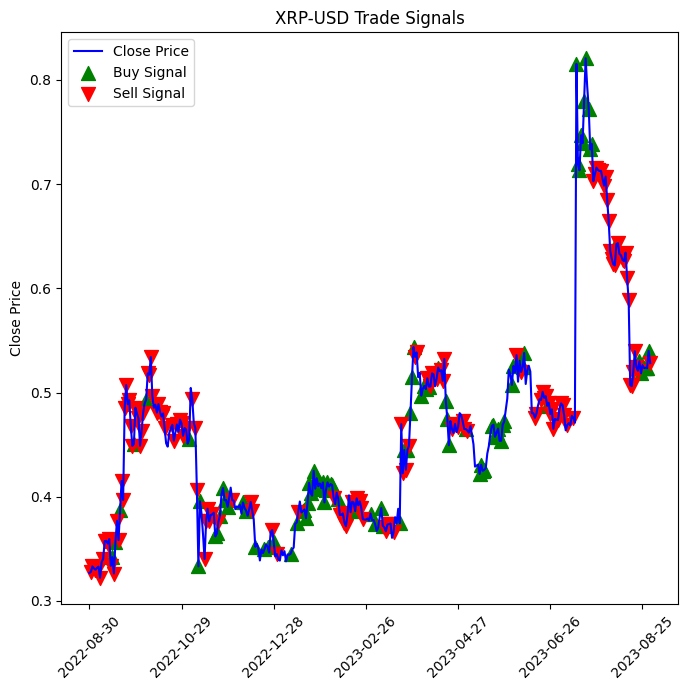

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd



# Create a DataFrame from the data
df = pd.DataFrame({'Date': dates, 'Close': CLOSES_1, 'Actions':ACTIONS})


# Create buy and sell signals based on Actions column
buy_indices = [i for i, val in enumerate(df['Actions']) if val == 1]
sell_indices = [i for i, val in enumerate(df['Actions']) if val == -1]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the Close price
ax.plot(df['Date'], df['Close'], label='Close Price', color='b')

# Plot buy signals (green)
ax.scatter(df['Date'][buy_indices], df['Close'][buy_indices], marker='^', color='g', label='Buy Signal', s=100)

# Plot sell signals (red)
ax.scatter(df['Date'][sell_indices], df['Close'][sell_indices], marker='v', color='r', label='Sell Signal', s=100)

# Set x-axis labels to be every two months
plt.xticks(df['Date'][::60], rotation=45)

# Set y-axis label
ax.set_ylabel('Close Price')

# Add a legend
ax.legend()

# Set the title
plt.title('XRP-USD Trade Signals')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
dates = test_env.asset_data.frame.index

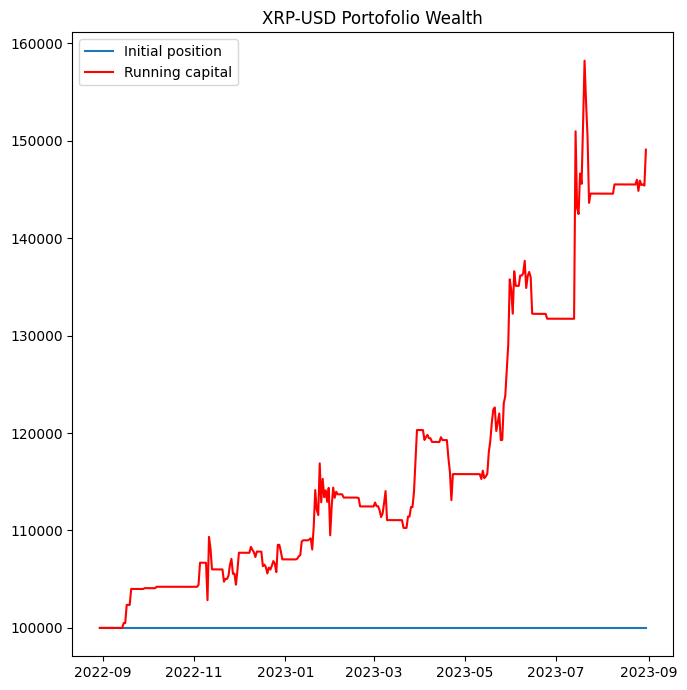

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

CAPITALS1=[CAPITAL]+CAPITALS[0]
ax.plot(dates,np.ones(len(dates))*CAPITAL, label='Initial position')
ax.plot(dates,CAPITALS1, label = 'Running capital', color='r')

# Add a legend
ax.legend()

# Show the plot
plt.title('XRP-USD Portofolio Wealth')
plt.tight_layout()
plt.show()


#plt.plot(dates,CAPITALS_1)

In [ ]:
x1=np.arange(len(scores_te)+1)
x=scores_te
y= ACTIONS
print(len(x))
print(len(y))
conditions =[y == -1, y == 0, y==1]
colors = np.array(['red', 'green', 'blue'])
color_list = np.select(conditions, colors)
plt.scatter(x1,x,c=color_list)


